In [16]:
#Imports
import warnings
warnings.filterwarnings(action='ignore')

from __future__ import print_function
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
# import coremltools
from scipy import stats
from IPython.display import display, HTML

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from tensorflow.keras.utils import to_categorical

In [17]:
# Set display styles
pd.options.display.float_format = '{:.1f}'.format
sns.set()
plt.style.use('ggplot')

print('keras version', keras.__version__)

# Class labels and time config
LABELS = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
TIME_PERIODS = 80
STEP_DISTANCE = 40

# Function to convert to float safely
def convert_to_float(x):
    try:
        return float(str(x).replace(';', '').strip())
    except:
        return np.nan

# Function to read and clean data
def read_data(file_path):
    column_names = ['user', 'activity', 'timestamp', 'x-axis', 'y-axis', 'z-axis']
    df = pd.read_csv(file_path, header=None, names=column_names)

    # Apply float conversion to 'z-axis' and others
    df['z-axis'] = df['z-axis'].apply(convert_to_float)
    df['x-axis'] = df['x-axis'].apply(convert_to_float)
    df['y-axis'] = df['y-axis'].apply(convert_to_float)

    # Drop rows with NaNs
    df.dropna(axis=0, how='any', inplace=True)
    return df

# Show shape info
def show_basic_dataframe_info(dataframe):
    print("Number of rows in the dataframe: %i" % (dataframe.shape[0]))
    print("Number of columns in the dataframe: %i" % (dataframe.shape[1]))

# Run the reading and check
df = read_data('/content/WISDM_ar_v1.1_raw.txt')
show_basic_dataframe_info(df)
df.head(10)

# set sample frequency (Dataset is equipped with 20S/s)
sample_freq = 2 # will down sample and take 1 sample /s from the dataset

# reset index so it's just a RangeIndex
df = df.reset_index(drop=True)

# downsample to 1Hz (considering original is ~20Hz)
df_1Hz = df.groupby(df.index // (20/sample_freq)).first().reset_index(drop=True)
show_basic_dataframe_info(df_1Hz)
print(df_1Hz.head())

keras version 3.8.0
Number of rows in the dataframe: 1098208
Number of columns in the dataframe: 6
Number of rows in the dataframe: 109821
Number of columns in the dataframe: 6
   user activity       timestamp  x-axis  y-axis  z-axis
0    33  Jogging  49105962326000    -0.7    12.7     0.5
1    33  Jogging  49106982315000    -8.2    19.6     2.7
2    33  Jogging  49108062271000     3.6    13.7     1.5
3    33  Jogging  49109132308000     3.9     3.8     0.8
4    33  Jogging  49110212326000     5.7     3.8     0.5


In [18]:


WINDOW_SIZE = 5  # 5 seconds
features, labels = [], []

for i in range(0, len(df_1Hz) - WINDOW_SIZE + 1):
    window = df_1Hz.iloc[i:i+WINDOW_SIZE]
    label = window['activity'].mode()[0]

    feat = []
    for axis in ['x-axis', 'y-axis', 'z-axis']:
        feat.extend([
            window[axis].mean(),
            window[axis].std(),
            window[axis].min(),
            window[axis].max()
        ])
    features.append(feat)
    labels.append(label)

X = np.array(features)
y = np.array(labels)


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

  Downstairs       0.79      0.41      0.54      2073
     Jogging       0.92      0.94      0.93      6787
     Sitting       1.00      0.99      0.99      1195
    Standing       0.99      0.97      0.98       952
    Upstairs       0.78      0.51      0.62      2471
     Walking       0.79      0.95      0.86      8486

    accuracy                           0.85     21964
   macro avg       0.88      0.79      0.82     21964
weighted avg       0.85      0.85      0.84     21964



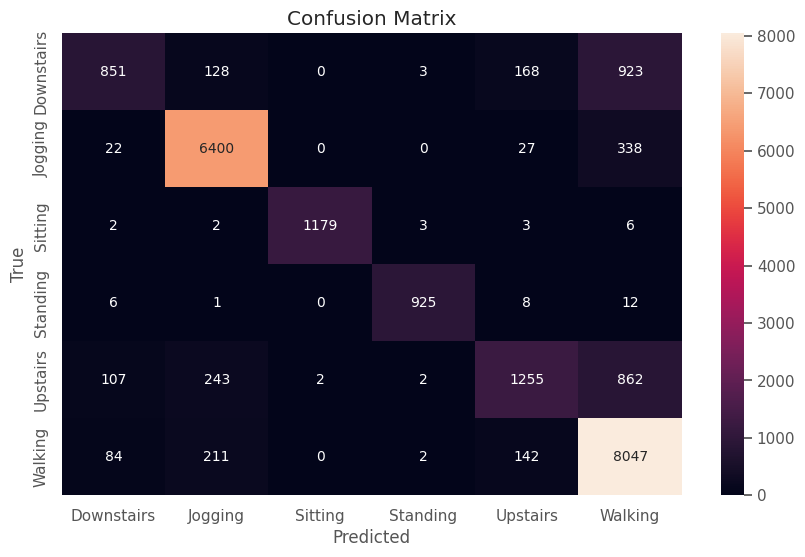

In [20]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()